# MANU 465 Team 7 (Metal 3D printing + Image)
# ANN Model

## Importing libraries and dataset

In [29]:
# importing libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sb
from keras.preprocessing.image import ImageDataGenerator
import keras.utils
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import classification_report
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
#from sklearn.utils.fixes import loguniform
import glob
import os
from PIL import Image,ImageOps

In [30]:
# importing the Elastic Modulus as the output 
# Data are imported from the 3-point bending experiment 
# First data is for beam 1, second is for beam 2.....
E=np.array ([57.71,
20.24,
32.43,
22.63,
64.28,
17.95,
17.67,
39.44,
9.33,
40.68,
26.56,
32.69,
57.93,
67.88,
222.46,
])

# repeating the E for the 47 different augmented image 
y=np.repeat(E, 47)

In [31]:
#y

In [32]:
my_path = "Z:/UBC/MANU465/Project/Single_beam_gcode/Single256/"
# Location to read all the images

# Get List of all images
files = glob.glob(my_path + '*.png', recursive=True)
images_dataset = []
filename_list=[]
# For each image
for file in files:
    # Get File name and extension
    filename = os.path.basename(file)
    
    # Open each image 
    im=Image.open(file).convert('L')
    filename_list.append(filename)
    img = np.array(im)
    img = img.flatten() 
    images_dataset.append(img) 
    
X=np.array(images_dataset)


In [33]:
#files

## Split the training and testing set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0
)

In [35]:
"""sc_x = StandardScaler()
X_train_scaled = sc_x.fit_transform(X_train)
X_test_scaled = sc_x.transform(X_test)

# Scale Y
sc_y = StandardScaler() 
y_train_scaled = sc_y.fit_transform(y_train.reshape(len(y_train),1))
y_test_scaled = sc_y.transform(y_test.reshape(len(y_test),1))
#Back to 1D array
y_train_scaled = y_train_scaled.reshape(len(y_train_scaled))
y_test_scaled = y_test_scaled.reshape(len(y_test_scaled))
np.shape(y_train_scaled)
"""

'sc_x = StandardScaler()\nX_train_scaled = sc_x.fit_transform(X_train)\nX_test_scaled = sc_x.transform(X_test)\n\n# Scale Y\nsc_y = StandardScaler() \ny_train_scaled = sc_y.fit_transform(y_train.reshape(len(y_train),1))\ny_test_scaled = sc_y.transform(y_test.reshape(len(y_test),1))\n#Back to 1D array\ny_train_scaled = y_train_scaled.reshape(len(y_train_scaled))\ny_test_scaled = y_test_scaled.reshape(len(y_test_scaled))\nnp.shape(y_train_scaled)\n'

<font color='red'> **We ended up doing the model without scaling because all x inputs are in the range of 0-255 and y are in the range of ~0-200. They are in the same order already** <br>
**Also, if some one wants to do scaling, don't use the code above for x variables, change it to scale between min and max. This is because using the above code will lead to the same pixel brightness (let say 128) be different in different locations.**

In [36]:
X_test.shape #

(141, 10496)

## PCA

Extracting the top 50 eigenvalues from 564 images


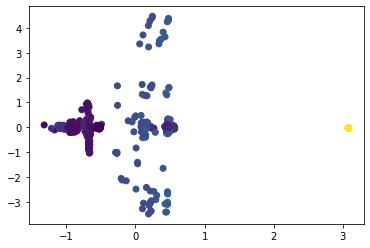

In [37]:
n_components = 50  # number of X_train samples ( PCA is limited to the minimum number of Samples and Features) 

print("Extracting the top %d eigenvalues from %d images" % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
#plot the transformed data
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train)

In [38]:
for count in range(0, len(X_train_pca[0,:])):
    print(np.var(X_train_pca[:,count]))

0.9982269503546081
0.998226950354612
0.9982269503546095
0.9982269503546087
0.9982269503546095
0.9982269503546103
0.9982269503546102
0.99822695035461
0.9982269503546063
0.9982269503546103
0.998226950354609
0.998226950354611
0.9982269503546102
0.9982269503546081
0.9982269503546127
0.9982269503546103
0.9982269503546102
0.9982269503546103
0.9982269503546092
0.9982269503546107
0.9982269503546093
0.9982269503546102
0.9982269503546115
0.9982269503546092
0.99822695035461
0.9982269503546102
0.9982269503546103
0.9982269503546092
0.9982269503546115
0.9982269503546127
0.9982269503546112
0.9982269503546115
0.9982269503546107
0.99822695035461
0.9982269503546092
0.99822695035461
0.9982269503546103
0.99822695035461
0.99822695035461
0.99822695035461
0.9982269503546103
0.9982269503546093
0.9982269503546103
0.9982269503546107
0.9982269503546097
0.9982269503546092
0.9982269503546075
0.9982269503546075
0.9982269503546093
0.9982269503546127


<font color='red'> **I am not sure what's going on but the variance after PCA looks super odd...The percentage of infor mation preserved is odd too. But it work...**

In [39]:
varsum_pca=0
varsum_dataset=0
#Calculate the sum or variance for 10 components PCA
for count in range(0, len(X_train_pca[0,:])):
    varsum_pca=varsum_pca+np.var(X_train_pca[:,count])
#Calculate the sum or variance in the dataset
for count in range(0, len(X_train[0,:])):
    varsum_dataset=varsum_dataset+np.var(X_train[:,count])
#Calculate how much information is preserved
print("The percentage of information preserved is",round(varsum_pca/varsum_dataset*100,3),"%")

The percentage of information preserved is 0.0 %


## Building the model with PCA

In [40]:
tf.keras.backend.clear_session()
model_with_pca=tf.keras.models.Sequential()  # initiazling 
model_with_pca.add(tf.keras.layers.Dense(50,activation='relu'))  # first hidden layer with 50 neurons = 50 features (PCA)
model_with_pca.add(tf.keras.layers.Dense(100,activation='relu'))
model_with_pca.add(tf.keras.layers.Dense(50,activation='relu'))
model_with_pca.add(tf.keras.layers.Dense(25,activation='relu'))  
model_with_pca.add(tf.keras.layers.Dense(12,activation='relu'))  
model_with_pca.add(tf.keras.layers.Dense(6,activation='relu'))
model_with_pca.add(tf.keras.layers.Dense(1)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_with_pca.compile(optimizer = opt, loss = 'MeanAbsoluteError', metrics = ['RootMeanSquaredError'])
History2=model_with_pca.fit(X_train_pca, y_train, batch_size = 32, epochs = 25, verbose=0)
#History = model_with_pca.fit(X_pca, y, validation_split=0.2, batch_size = 32, epochs = 50, verbose=0)

dict_keys(['loss', 'root_mean_squared_error'])


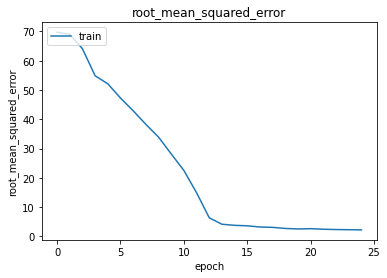

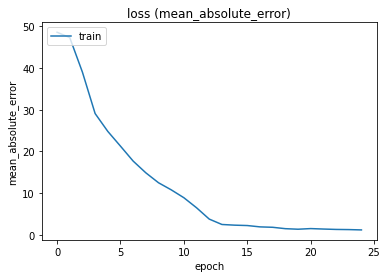

In [41]:
print(History2.history.keys())

plt.plot(History2.history['root_mean_squared_error'])
plt.title('root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History2.history['loss'])
plt.title('loss (mean_absolute_error)')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


5/5 [==============================] - 0s 1ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

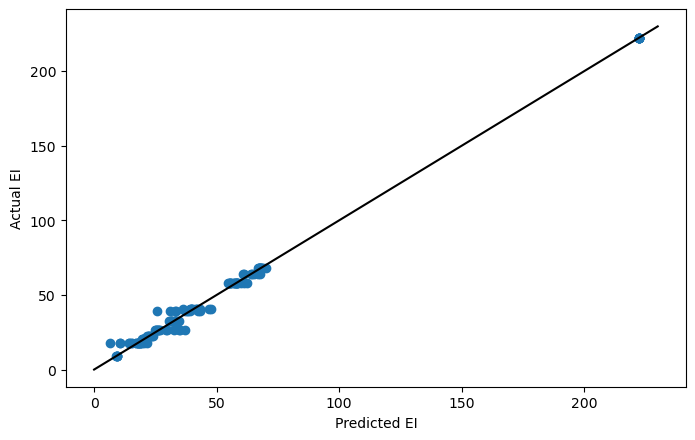

In [42]:
X_ideal=[0,230]
y_ideal=[0,230]
y_pred=model_with_pca.predict(X_test_pca)
plt.figure(figsize = [8,5], dpi = 100)
plt.scatter(y_pred,y_test)
plt.plot(X_ideal,y_ideal,color='black')
plt.ylabel('Actual EI')
plt.xlabel('Predicted EI')
plt.show

In [43]:
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
w_pca_MAE=mean_absolute_error(y_test,y_pred)
w_pca_RMSE=mean_squared_error(y_test,y_pred,squared=False)
print('MAE Score: ', round(w_pca_MAE,3))
print('RMSE Score: ', round(w_pca_RMSE,3))

MAE Score:  1.778
RMSE Score:  2.992


## Building the model without PCA

In [61]:
tf.keras.backend.clear_session()
model_without_pca=tf.keras.models.Sequential()  # initiazling 
model_without_pca.add(tf.keras.layers.Dense(10496,activation='relu'))
model_without_pca.add(tf.keras.layers.Dense(2624,activation='relu'))
model_without_pca.add(tf.keras.layers.Dense(656,activation='relu'))  
model_without_pca.add(tf.keras.layers.Dense(164,activation='relu'))  
model_without_pca.add(tf.keras.layers.Dense(41,activation='relu'))
model_without_pca.add(tf.keras.layers.Dense(12,activation='relu'))
model_without_pca.add(tf.keras.layers.Dense(4,activation='relu'))
model_without_pca.add(tf.keras.layers.Dense(1)) # output layer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_without_pca.compile(optimizer = opt, loss = 'MeanAbsoluteError', metrics = ['RootMeanSquaredError'])
History3=model_without_pca.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose=1)

Epoch 1/50
18/18 [==============================] - 7s 351ms/step - loss: 2717.2153 - root_mean_squared_error: 3795.3169
Epoch 2/50
18/18 [==============================] - 6s 352ms/step - loss: 199.6382 - root_mean_squared_error: 343.3794
Epoch 3/50
18/18 [==============================] - 6s 342ms/step - loss: 25.1469 - root_mean_squared_error: 41.9312
Epoch 4/50
18/18 [==============================] - 6s 345ms/step - loss: 20.2784 - root_mean_squared_error: 39.3861
Epoch 5/50
18/18 [==============================] - 6s 347ms/step - loss: 18.9342 - root_mean_squared_error: 38.3263
Epoch 6/50
18/18 [==============================] - 6s 347ms/step - loss: 14.7148 - root_mean_squared_error: 33.8876
Epoch 7/50
18/18 [==============================] - 6s 340ms/step - loss: 12.8336 - root_mean_squared_error: 31.6547
Epoch 8/50
18/18 [==============================] - 6s 341ms/step - loss: 11.8236 - root_mean_squared_error: 29.7221
Epoch 9/50
18/18 [==============================] - 6s 344

<font color='red'> **Sometimes the model won't converge and loss is not really changing in the first few epoches...Rerun a few times and it's good again**

dict_keys(['loss', 'root_mean_squared_error'])


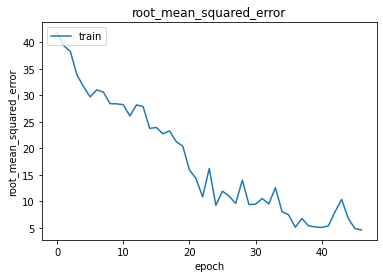

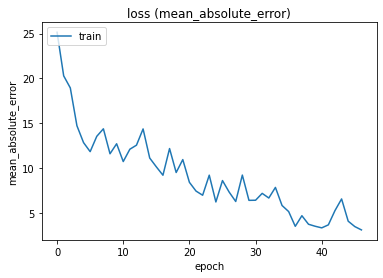

In [62]:
print(History3.history.keys())
#Skip the number for first 2 epoch as they are huge
#metrics (RMSE)
plt.plot(History3.history['root_mean_squared_error'][2:-1])
plt.title('root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss (MAE)
plt.plot(History3.history['loss'][2:-1])
plt.title('loss (mean_absolute_error)')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 44ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

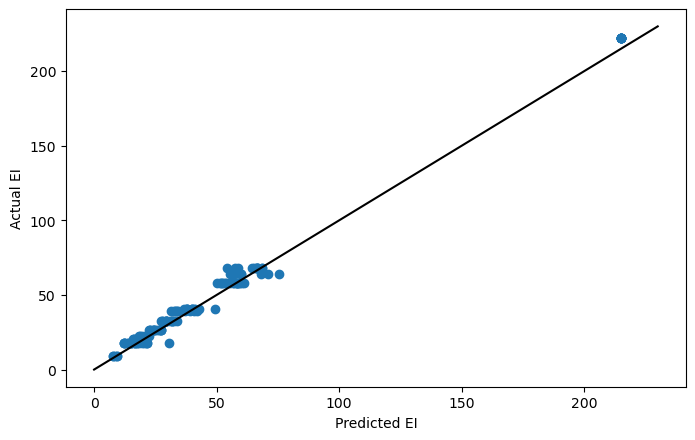

In [63]:
X_ideal=[0,230]
y_ideal=[0,230]
y_pred_without=model_without_pca.predict(X_test)
plt.figure(figsize = [8,5], dpi = 100)
plt.scatter(y_pred_without,y_test)
plt.plot(X_ideal,y_ideal,color='black')
plt.ylabel('Actual EI')
plt.xlabel('Predicted EI')
plt.show

<font color='red'> **The loss vs epoch graph looks good with no obvious underfitting or overfitting. The result of the test set also looks good, except that the PCA model converges with fewer epochs and has a lower MAE than this one. It's also faster in terms of prediction and model generation (did not take into account PCA process time).**

In [65]:
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
wo_pca_MAE=mean_absolute_error(y_test,y_pred_without)
wo_pca_RMSE=mean_squared_error(y_test,y_pred_without,squared=False)
print('MAE Score: ', round(wo_pca_MAE,3))
print('RMSE Score: ', round(wo_pca_RMSE,3))

MAE Score:  3.326
RMSE Score:  4.326
